In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from mpl_toolkits.basemap import Basemap
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from yellowbrick.cluster import silhouette_visualizer
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("earthquakes_2023_global.csv")
df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-01-01T00:49:25.294Z,52.0999,178.5218,82.770,3.10,ml,14.0,139.0,0.8700,0.18,...,2023-03-11T22:51:52.040Z,"Rat Islands, Aleutian Islands, Alaska",earthquake,8.46,21.213,0.097,14.0,reviewed,us,us
1,2023-01-01T01:41:43.755Z,7.1397,126.7380,79.194,4.50,mb,32.0,104.0,1.1520,0.47,...,2023-03-11T22:51:45.040Z,"23 km ESE of Manay, Philippines",earthquake,5.51,7.445,0.083,43.0,reviewed,us,us
2,2023-01-01T03:29:31.070Z,19.1631,-66.5251,24.000,3.93,md,23.0,246.0,0.8479,0.22,...,2023-03-11T22:51:29.040Z,Puerto Rico region,earthquake,0.91,15.950,0.090,16.0,reviewed,pr,pr
3,2023-01-01T04:09:32.814Z,-4.7803,102.7675,63.787,4.30,mb,17.0,187.0,0.4570,0.51,...,2023-03-11T22:51:45.040Z,"99 km SSW of Pagar Alam, Indonesia",earthquake,10.25,6.579,0.238,5.0,reviewed,us,us
4,2023-01-01T04:29:13.793Z,53.3965,-166.9417,10.000,3.00,ml,19.0,190.0,0.4000,0.31,...,2023-03-11T22:51:38.040Z,"59 km SSW of Unalaska, Alaska",earthquake,1.41,1.999,0.085,18.0,reviewed,us,us


In [3]:
#get numerical columns
num_col = df.select_dtypes(include='float64')
num_col

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
0,52.0999,178.5218,82.770,3.10,14.0,139.0,0.8700,0.18,8.46,21.213,0.097,14.0
1,7.1397,126.7380,79.194,4.50,32.0,104.0,1.1520,0.47,5.51,7.445,0.083,43.0
2,19.1631,-66.5251,24.000,3.93,23.0,246.0,0.8479,0.22,0.91,15.950,0.090,16.0
3,-4.7803,102.7675,63.787,4.30,17.0,187.0,0.4570,0.51,10.25,6.579,0.238,5.0
4,53.3965,-166.9417,10.000,3.00,19.0,190.0,0.4000,0.31,1.41,1.999,0.085,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26637,-6.9527,154.9829,10.000,5.20,72.0,60.0,3.9240,0.93,10.07,1.765,0.048,141.0
26638,32.3262,141.7386,10.000,5.10,74.0,121.0,1.8030,0.70,9.17,1.870,0.042,187.0
26639,-7.2411,68.0663,10.000,5.10,60.0,54.0,12.7760,0.57,8.02,1.792,0.090,40.0
26640,-19.1602,169.0428,153.264,4.70,40.0,61.0,3.7460,0.82,8.52,7.433,0.081,46.0


In [4]:
num_col.dropna()
num_col.isnull().sum()

latitude              0
longitude             0
depth                 0
mag                   0
nst                1415
gap                1417
dmin               1866
rms                   0
horizontalError    1549
depthError            0
magError           1672
magNst             1577
dtype: int64

In [5]:
from sklearn.experimental import enable_iterative_imputer #must be included to enable the usage of the imputer
from sklearn.impute import IterativeImputer

num_iterimpute = IterativeImputer(random_state=0)
clean_num_col = pd.DataFrame(num_iterimpute.fit_transform(num_col))
clean_num_col.columns = num_col.columns

display(num_col.isna().sum())
display(clean_num_col.isna().sum())

latitude              0
longitude             0
depth                 0
mag                   0
nst                1415
gap                1417
dmin               1866
rms                   0
horizontalError    1549
depthError            0
magError           1672
magNst             1577
dtype: int64

latitude           0
longitude          0
depth              0
mag                0
nst                0
gap                0
dmin               0
rms                0
horizontalError    0
depthError         0
magError           0
magNst             0
dtype: int64

In [6]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Select the columns to exclude from normalization
columns_to_exclude = ['latitude', 'longitude']

# Select the columns to normalize
columns_to_normalize = [col for col in clean_num_col.columns if col not in columns_to_exclude]

# Fit the scaler on the selected columns
scaler = MinMaxScaler().fit(clean_num_col[columns_to_normalize])

# Transform the selected columns
newdf_norm = clean_num_col.copy()
newdf_norm[columns_to_normalize] = scaler.transform(clean_num_col[columns_to_normalize])

newdf_norm

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
0,52.0999,178.5218,0.125824,0.096154,0.058932,0.383041,0.257564,0.090909,0.090970,0.349646,0.021604,0.018175
1,7.1397,126.7380,0.120600,0.365385,0.100348,0.280702,0.261755,0.245989,0.061352,0.122713,0.018486,0.050902
2,19.1631,-66.5251,0.039979,0.255769,0.079640,0.695906,0.257235,0.112299,0.015167,0.262898,0.020045,0.020432
3,-4.7803,102.7675,0.098096,0.326923,0.065834,0.523392,0.251425,0.267380,0.108942,0.108439,0.053007,0.008018
4,53.3965,-166.9417,0.019529,0.076923,0.070436,0.532164,0.250578,0.160428,0.020187,0.032949,0.018931,0.022689
...,...,...,...,...,...,...,...,...,...,...,...,...
26637,-6.9527,154.9829,0.019529,0.500000,0.192384,0.152047,0.302957,0.491979,0.107135,0.029092,0.010690,0.161499
26638,32.3262,141.7386,0.019529,0.480769,0.196986,0.330409,0.271432,0.368984,0.098098,0.030822,0.009354,0.213411
26639,-7.2411,68.0663,0.019529,0.480769,0.164773,0.134503,0.434530,0.299465,0.086552,0.029537,0.020045,0.047517
26640,-19.1602,169.0428,0.228794,0.403846,0.118755,0.154971,0.300311,0.433155,0.091572,0.122515,0.018040,0.054288


In [7]:
from sklearn.cluster import KMeans

# set number of cluster to get labels
km = KMeans(n_clusters = 2, random_state=1)
km.fit(newdf_norm)

KMeans(n_clusters=2, random_state=1)

In [8]:
# Merge cluster set
df_clustered = newdf_norm.copy()
df_clustered['label']=km.labels_
df_clustered

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,label
0,52.0999,178.5218,0.125824,0.096154,0.058932,0.383041,0.257564,0.090909,0.090970,0.349646,0.021604,0.018175,1
1,7.1397,126.7380,0.120600,0.365385,0.100348,0.280702,0.261755,0.245989,0.061352,0.122713,0.018486,0.050902,1
2,19.1631,-66.5251,0.039979,0.255769,0.079640,0.695906,0.257235,0.112299,0.015167,0.262898,0.020045,0.020432,0
3,-4.7803,102.7675,0.098096,0.326923,0.065834,0.523392,0.251425,0.267380,0.108942,0.108439,0.053007,0.008018,1
4,53.3965,-166.9417,0.019529,0.076923,0.070436,0.532164,0.250578,0.160428,0.020187,0.032949,0.018931,0.022689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26637,-6.9527,154.9829,0.019529,0.500000,0.192384,0.152047,0.302957,0.491979,0.107135,0.029092,0.010690,0.161499,1
26638,32.3262,141.7386,0.019529,0.480769,0.196986,0.330409,0.271432,0.368984,0.098098,0.030822,0.009354,0.213411,1
26639,-7.2411,68.0663,0.019529,0.480769,0.164773,0.134503,0.434530,0.299465,0.086552,0.029537,0.020045,0.047517,1
26640,-19.1602,169.0428,0.228794,0.403846,0.118755,0.154971,0.300311,0.433155,0.091572,0.122515,0.018040,0.054288,1


In [9]:
label_counts = df_clustered['label'].value_counts()

# Display the counts
print("Count of label 0:", label_counts.get(0, 0))
print("Count of label 1:", label_counts.get(1, 0))
# print("Count of label 2:", label_counts.get(2, 0))

Count of label 0: 14534
Count of label 1: 12108


label
0    14534
1    12108
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

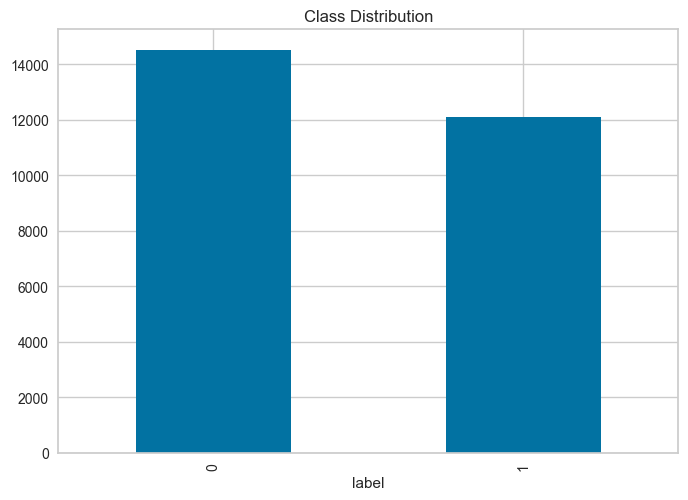

In [10]:
print(df_clustered["label"].value_counts())
df_clustered["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")

In [13]:
# SMOTE
import imblearn
smt = imblearn.over_sampling.SMOTE(sampling_strategy="minority", random_state=42, k_neighbors=5)

# Min Max Normalization on the features (without target)
X = df_clustered.drop(["label","latitude","longitude"], axis=1)
y = df_clustered["label"]
features = X.columns

,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
0,0.125824,0.096154,0.058932,0.383041,0.257564,0.090909,0.090970,0.349646,0.021604,0.018175
1,0.120600,0.365385,0.100348,0.280702,0.261755,0.245989,0.061352,0.122713,0.018486,0.050902
2,0.039979,0.255769,0.079640,0.695906,0.257235,0.112299,0.015167,0.262898,0.020045,0.020432
3,0.098096,0.326923,0.065834,0.523392,0.251425,0.267380,0.108942,0.108439,0.053007,0.008018
4,0.019529,0.076923,0.070436,0.532164,0.250578,0.160428,0.020187,0.032949,0.018931,0.022689
...,...,...,...,...,...,...,...,...,...,...
26637,0.019529,0.500000,0.192384,0.152047,0.302957,0.491979,0.107135,0.029092,0.010690,0.161499
26638,0.019529,0.480769,0.196986,0.330409,0.271432,0.368984,0.098098,0.030822,0.009354,0.213411
26639,0.019529,0.480769,0.164773,0.134503,0.434530,0.299465,0.086552,0.029537,0.020045,0.047517
26640,0.228794,0.403846,0.118755,0.154971,0.300311,0.433155,0.091572,0.122515,0.018040,0.054288


In [ ]:
# Fit smote
X_res, y_res = smt.fit_resample(X, y)

In [ ]:
print(y_res.value_counts())
y_res.value_counts().plot(kind="bar")
plt.title("Class Distribution")